In [1]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [2]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

In [ ]:
###### Music Transformer version of our network ######
# Uses the relative position representation from the Music Transformer


# HuangMHA: multi-headed attention using relative position representation
# (specifically, the representation introduced by Shaw and optimized by Huang)

In [120]:
##### TransformerXL version of our network #####

# Baseline Transformer definition
Uses absolute position representation

In [3]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for multiple instruments and batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].view(x.shape[0], 1, 1, -1).expand(-1, x.shape[1], x.shape[2], -1)
        return self.dropout(x)
        

# EnsembleTransformer: takes a history of MIDI messages 
# for instruments in an ensemble and generates a distribution for the next message
# for a specific instrument
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    def __init__(self, message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size):
        super(EnsembleTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # We add the tanhed instrument embedding to each input message 
        # (this is the global conditioning idea from DeepJ, which comes from WaveNet)
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        
        self.position_encoding = PositionalEncoding(embed_dim)
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # A decoder is used to transform the history of the instrument we're generating
        # music for, then combine this with the other histories to generate the next message
        decoder_layer = torch.nn.TransformerDecoderLayer(embed_dim, heads, ff_size)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, attention_layers)
        
        self.logits = torch.nn.Linear(embed_dim, message_dim)
    
    # forward: generates a probability distribution for the next MIDI message
    # for an instrument, given the message history of the ensemble
    # ARGUMENTS
    # history: an LxNxB tensor, where L is the length of the longest history in
    # the batch, N is the max number of instruments in the batch, and B is the batch size. As we
    # walk along the first dimension, we should see indices of MIDI events for a particular
    # instrument
    # mask: an LxNxB tensor, containing True where a message or instrument doesn't exist
    # instruments: a 1xNxB tensor indicating the instrument numbers for each batch
    # gen_idx: a the index (along dimension 1 of history) of the instrument we want to generate music for
    # seq_lengths: an NxB tensor indicating the length of each unpadded sequence
    # RETURN: an LxBxD tensor, representing the distribution for
    # the next MIDI message for the instrument indicated by gen_idx at each time step. 
    # Note, to get the actual probabilities you'll have to take the softmax
    # of this tensor along dimension 1
    def forward(self, history, mask, instruments, gen_idx, seq_lengths):
        L = history.shape[0] # longest length
        N = history.shape[1] # max instruments
        B = history.shape[2] # batch size
        assert(instruments.shape == (1, N, B))
        assert(mask.shape == history.shape)
        
        inputs = self.embedding(history) + torch.tanh(self.i_embedding(instruments)).expand(L, -1, -1, -1)
        
        inputs = self.position_encoding(inputs)
        
        memory_key_padding_mask = torch.zeros((1, 1), dtype=torch.bool)
        if N == 1:
            memory = torch.zeros((1, B, self.embed_dim))
            mem_lengths = None
        else:
            memory_idx = [i for i in range(N) if i != gen_idx]
            memory = inputs[:, memory_idx]
            memory_key_padding_mask = mask[:, memory_idx]
            mem_lengths = seq_lengths[memory_idx]

        decoder_inputs = inputs[:, gen_idx]
        tgt_key_padding_mask = mask[:, gen_idx].transpose(0, 1)
        
        chunk_size = 200
        decoding = torch.zeros((L, B, embed_dim))
        
        # Only works for batch size 1
        decode_L = seq_lengths[gen_idx, 0]
        
        for i in range(decode_L%chunk_size, decode_L + 1, chunk_size):
            if i == 0:
                continue
                
            end = i
            start = max(end - chunk_size, 0)
            size = end - start
            
            tgt_mask = torch.triu(torch.ones((size, size), dtype=torch.bool))
            tgt_mask.fill_diagonal_(False)
            
            decoder_input_chunk = decoder_inputs[start:end]
            
            tgt_chunk_key_padding_mask = tgt_key_padding_mask[:, start:end]
            
            if N == 1:
                memory_chunk = memory
                memory_chunk_key_padding_mask = memory_key_padding_mask
                memory_mask = None
            else:
                memory_chunk = torch.zeros((size, N - 1, B, embed_dim))
                memory_chunk_key_padding_mask = torch.ones((size, N - 1, B), dtype=torch.bool)
                memory_mask = torch.zeros((size, size*(N - 1)), dtype=torch.bool)
                for i in range(N - 1):
                    for b in range(B):
                        mem_end = min(mem_lengths[i, b], end)
                        mem_start = max(mem_end - size, 0)
                        mem_size = mem_end - mem_start
                        memory_chunk[:mem_size, i, b] = memory[mem_start:mem_end, i, b]
                        memory_chunk_key_padding_mask[:mem_size, i, b] = memory_key_padding_mask[mem_start:mem_end, i, b]
                        
                        # This is a hack that only works for batch size B = 1
                        mem_mask_end = size*(i + 1)
                        mem_mask_start = min(size*i + start - mem_start + 1, mem_mask_end)
                        memory_mask[:, mem_mask_start:mem_mask_end] = torch.triu(torch.ones((size, mem_mask_end - mem_mask_start), dtype=torch.bool))
                    
                memory_chunk = memory_chunk.view(-1, B, embed_dim)
                memory_chunk_key_padding_mask = memory_chunk_key_padding_mask.view(-1, B).transpose(0, 1)
                
            assert(not memory_mask.all())               
            assert(not memory_chunk_key_padding_mask.all())
            assert(not tgt_mask.all())
            assert(not tgt_chunk_key_padding_mask.all())
            assert(tgt_mask.shape[0] == decoder_input_chunk.shape[0])

            decoding[start:end] = self.decoder(decoder_input_chunk, \
                                               memory_chunk, \
                                               tgt_mask=tgt_mask, \
                                               memory_mask=memory_mask, \
                                               tgt_key_padding_mask=tgt_chunk_key_padding_mask, \
                                               memory_key_padding_mask=memory_chunk_key_padding_mask)
                
        return self.logits(decoding)

# Tests for baseline transformer
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single instrument's part in a single song (only the first 100 time steps). Tests decoder

In [ ]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout

In [ ]:
model.load_state_dict(torch.load('overfit_single_instrument.pth'))

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

inst = 1

max_seq_length = 1000

history = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros(history.shape, dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
seq_lengths = torch.tensor(max_seq_length).view(1, 1)

max_instruments = history.shape[1]

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 150
train_losses = np.zeros(epochs)

target_messages = history[1:].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    # Index of the instrument we want to generate music for (there's only one instrument)
    gen_idx = 0
    
    # Move forward in time
    logits = model(history[:-1], mask[:-1], instruments, gen_idx, seq_lengths).view(-1, message_dim)
                
    loss = loss_fn(logits, target_messages)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

In [48]:
torch.save(model.state_dict(), 'overfit_single_instrument2.pth')

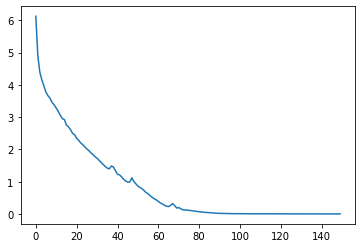

In [47]:
plt.plot(train_losses)

In [12]:
# Sample from model
gen_history = torch.tensor(recording[inst][0], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

seq_length = 100
max_instruments = history.shape[1]

# Index of the instrument we want to generate music for (there's only one instrument)
gen_idx = 0

# Move forward in time
wrong_cnt = 0
for t in range(1, seq_length):
    logits = model(gen_history, mask, instruments, gen_idx)
    probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
    gen_history = torch.cat((gen_history, torch.multinomial(probs, 1).view(1, 1, -1)))
    #gen_history = torch.cat((gen_history, torch.argmax(probs.flatten()).view(1, 1, 1)))
    if torch.argmax(probs.flatten()) != history[t].flatten():
        wrong_cnt += 1
        print(torch.topk(probs.flatten(), 10))
        print(history[t])
    
    mask = torch.cat((mask, torch.zeros((1, 1, 1), dtype=torch.bool)))

print(wrong_cnt)

0


In [63]:
np.save('test_history.npy', np.array([history.flatten().numpy()], dtype='object'))
np.save('test_instruments.npy', np.array([instrument_numbers[instruments[0]]]))

Get the model to overfit to two instruments' parts in a single song

In [134]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [123]:
model.load_state_dict(torch.load('overfit_two_instruments_memchunk.pth'))

<All keys matched successfully>

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_seq_length = 1000
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 300
train_losses = np.zeros(epochs)
num_targets = max_seq_length - 1

seq_lengths = torch.tensor(max_seq_length).view(1, 1).expand(2, -1)

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    loss = torch.tensor([0], dtype=torch.float32)
    for inst in range(max_instruments):
        logits = model(history[:-1], mask[:-1], instruments, inst, seq_lengths)

        logits = logits.view(-1, message_dim)
        target_messages = history[1:, inst].flatten()
        output_mask = torch.logical_not(mask[1:, inst].flatten())
        loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
                
    loss = loss/max_instruments
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss = %f' %(loss.data))

In [67]:
torch.save(model.state_dict(), 'overfit_two_instruments_memchunk.pth')

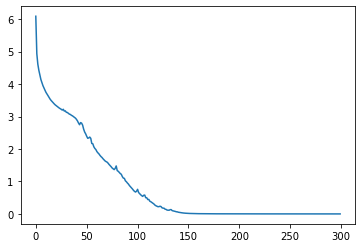

In [16]:
plt.plot(train_losses)

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_seq_length = 1000
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False

# Check if the instruments can jointly reconstruct the piece
gen_history = history.clone()

model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

wrong_cnt = 0

for t in range(1, max_seq_length):
    input_mask = mask.clone()
    input_mask[t:] = True
    seq_lengths = torch.tensor(t).view(1, 1).expand(max_instruments, 1)
    for inst in range(max_instruments):
        logits = model(gen_history, input_mask, instruments, inst, seq_lengths)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        #gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        gen_history[t, inst, 0] = torch.argmax(probs.flatten())
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
            print('wrong')
           
    if t%50 == 0:
        print(t)

print(wrong_cnt)

Test sequences of different length

In [63]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

length1 = 500
length2 = 1000
max_seq_length = 1000

seq_lengths = torch.tensor([length1, length2]).unsqueeze(1)

max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:seq_lengths[inst], inst, 0] = torch.tensor(recording[inst][:seq_lengths[inst]], dtype=torch.long)
    mask[:seq_lengths[inst], inst, 0] = False

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 300
train_losses = np.zeros(epochs)

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    loss = torch.tensor([0], dtype=torch.float32)
    for inst in range(max_instruments):
        num_targets = seq_lengths[inst] - 1
        
        logits = model(history[:-1], mask[:-1], instruments, inst, seq_lengths - 1)

        logits = logits.view(-1, message_dim)
        target_messages = history[1:, inst].flatten()
        output_mask = torch.logical_not(mask[1:, inst].flatten())
        loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
                
    loss = loss/max_instruments
    optimizer.zero_grad()
    loss.backward()
    
    '''
    for name, p in model.named_parameters():
        if p.grad is not None:
            print(name)
            print(p.grad.norm())
    '''
    
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss = %f' %(loss.data))

In [ ]:
# Check if the instruments can jointly reconstruct the piece
gen_history = history.clone()

model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

wrong_cnt = 0

gen_seq_lengths = torch.tensor([1, 1]).view(max_instruments, 1)

for t in range(1, max_seq_length):
    input_mask = mask.clone()
    input_mask[t:] = True
    for inst in range(max_instruments):
        if seq_lengths[inst, 0] >= t:
            continue
            
        logits = model(gen_history, input_mask, instruments, inst, gen_seq_lengths)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        #gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        gen_history[t, inst, 0] = torch.argmax(probs.flatten())
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
            print('wrong')
           
    if t%50 == 0:
        print(t)

print(wrong_cnt)

# Custom dataset class

In [8]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is a numpy array of message sequences for each instrument
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True)}
        
        assert(len(instance['history']) == len(instance['instruments']))
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [9]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxNxB tensor containing messages
# sample['instruments']: a 1xNxB tensor containing instrument numbers
# sample['mask']: an LxNxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
# sample['seq_lengths']: an NxB tensor containing the length of each sequence
def collate_fn(batch):
    length_cap = 10000
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest ensemble
    max_instruments = max([len(instance['history']) for instance in batch])
    longest_len = min(max([max([seq.shape[0] for seq in instance['history']]) for instance in batch]), length_cap)

    sample = {'history': torch.ones((longest_len, max_instruments, batch_size), dtype=torch.long), \
              'instruments': torch.zeros((1, max_instruments, batch_size), dtype=torch.long), \
              'mask': torch.ones((longest_len, max_instruments, batch_size), dtype=torch.bool), \
              'seq_lengths': torch.zeros((max_instruments, batch_size), dtype=torch.long)}

    for b in range(batch_size):
        instrument_idx = [instrument_numbers.index(inst) for inst in batch[b]['instruments']]
        sample['instruments'][0, :len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        
        for inst_idx in range(len(batch[b]['history'])):
            seq_length = min(length_cap, len(batch[b]['history'][inst_idx]))
            sample['seq_lengths'][inst_idx, b] = seq_length
            sample['history'][:seq_length, inst_idx, b] = torch.tensor(batch[b]['history'][inst_idx][:seq_length], dtype=torch.long)
            sample['mask'][:seq_length, inst_idx, b] = False
            
    return sample

# Train the model

In [12]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, len(instrument_numbers), heads, attention_layers, ff_size)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [11]:
batch_size = 1
learning_rate = 0.001

dataset = MIDIDataset('preprocessed_data')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split. Can we do this with Dataloader?

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    for b, batch in enumerate(dataloader):
        print('Starting iteration %d' %(b))
        max_seq_length = batch['history'].shape[0]
        num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1
        max_instruments = batch['history'].shape[1]
        loss = torch.tensor([0])
        for inst in range(max_instruments):         
            mask = batch['mask']
            
            logits = model(batch['history'][:-1], mask[:-1], batch['instruments'], inst, batch['seq_lengths'] - 1)
            logits = logits.view(-1, message_dim)
            target_messages = batch['history'][1:, inst].flatten()
            output_mask = torch.logical_not(mask[1:, inst].flatten())
            loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
        
        loss /= max_instruments
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses[epoch] += loss.data

Starting epoch 0
Starting iteration 0
tensor([6.1357])
Starting iteration 1
tensor([5.9965])
Starting iteration 2
tensor([5.8795])
Starting iteration 3
tensor([6.1061])
Starting iteration 4


RuntimeError: python_error

# Sample from the model

In [ ]:
model.eval() # Disable dropout to make results repeatable

time_steps = 5000 # How many time steps do we sample?

max_instruments = 3

# Piano, violin, viola
instruments = torch.tensor([0, 2, 3]).view(1, max_instruments, 1)

# Suppose they all start with the same velocity message
# TODO: should we have SOS and EOS tokens like in NLP?
gen_history = 24*torch.ones((1, max_instruments, 1), dtype=torch.long)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)

for t in range(1, time_steps):
    # Sanity check
    if t%100 == 0:
        print(t)
    next_messages = torch.zeros((1, max_instruments, 1), dtype=torch.long)
    seq_lengths = torch.tensor(gen_history.shape[0]).view(1, 1).expand(max_instruments, -1)
    for inst in range(max_instruments):
        logits = model(gen_history, mask.expand(t, max_instruments, -1), instruments, inst, seq_lengths)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        next_messages[0, inst, 0] = torch.multinomial(probs, 1)
    
    gen_history = torch.cat((gen_history, next_messages))